<a href="https://colab.research.google.com/github/solharsh/Lending_Club_Analysis_and_Modeling/blob/master/Lending_Club_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is second notebook and continued after performing EDA on the lending club dataset. In this notebook, I will be doing following: 

- NLP Implementation on desc column
- Split the training and test data considering the timeline of our data instead of random splitting. 

As per today's case study discussed by Dipyaman, I will make our modeling problem more realistic by performing the train/test split based on the month that the loan was funded. That is, we'll use loans funded on earlier dates to predict whether future loans will charge-off. The variable issue_d includes the month and year that the loan was funded.

# 1. Read cleaned final data

In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive


In [0]:
import pandas as pd 
df = pd.read_pickle("/content/drive/My Drive/Lending_Club/data_selected.pkl")

In [12]:
df.head()

,loan_amnt,term,emp_length,loan_status,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc,tot_coll_amt,tot_cur_bal,mort_acc,pub_rec_bankruptcies,earliest_cr_line_n,fico_avg,log_annual_inc,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Source Verified,verification_status_Verified,purpose_n_life_events,purpose_n_major_purchases,purpose_n_other,initial_list_status_w
0,5000,36,10,0,0.002765,3.0,0.0,4.135101,83.7,9.0,0.0,0.0,0.0,0.0,35.337440,737.0,4.380229,0,0,1,0,1,0,0,0,0
1,2500,60,1,1,0.000100,3.0,0.0,3.227372,9.4,4.0,0.0,0.0,0.0,0.0,21.092402,742.0,4.477136,0,0,1,1,0,0,1,0,0
2,2400,36,10,0,0.000872,2.0,0.0,3.470851,98.5,10.0,0.0,0.0,0.0,0.0,18.505133,737.0,4.088242,0,0,1,0,0,1,0,0,0
3,10000,36,10,0,0.002000,10.0,0.0,3.748110,21.0,37.0,0.0,0.0,0.0,0.0,24.254620,692.0,4.691974,0,0,1,1,0,0,0,1,0
4,3000,60,1,0,0.001794,15.0,0.0,4.443795,53.9,38.0,0.0,0.0,0.0,0.0,24.339493,697.0,4.903095,0,0,1,1,0,0,0,1,0


In [13]:
print('There are {} rows and {} columns in the dataset.'.format(df.shape[0],df.shape[1]))

There are 334262 rows and 26 columns in the dataset.


# 2. Importing Libraries

In [14]:
# Import our libraries we are going to use for our data analysis.
import tensorflow as tf
import pickle
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import pyplot as plt
import nltk
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import preprocessing
from sklearn.utils import class_weight


# For oversampling Library (Dealing with Imbalanced Datasets)
from imblearn.over_sampling import SMOTE
from collections import Counter

# Other Libraries
import time

% matplotlib inline
#NLP
import nltk
nltk.download('words')
nltk.download("stopwords") 
nltk.download('punkt')
nltk.download('wordnet')
# Importing the necessary functions
import nltk, re
from nltk.corpus import stopwords
stop = stopwords.words('english')
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
words = set(nltk.corpus.words.words())
import string

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# 3. Natural Language Processing Implementation on 'desc' column!

In [0]:
raw_df = pd.read_csv("/content/drive/My Drive/Capstone Project - NLP/fullacc.csv",low_memory=False)

In [16]:
raw_df['desc'].head()

0      Borrower added on 12/22/11 > I need to upgra...
1      Borrower added on 12/22/11 > I plan to use t...
2                                                  NaN
3      Borrower added on 12/21/11 > to pay for prop...
4      Borrower added on 12/21/11 > I plan on combi...
Name: desc, dtype: object

In [17]:
print(raw_df['desc'].isna().sum())

223541


We have too many missing values and we can simply replace the NaNs with a placeholder value

In [0]:
#Let's fill-in the missing values for desc column above. We will just use the placeholder "Missing" here.
raw_df['desc'].fillna("Missing", inplace=True)

In [19]:
raw_df['desc'].shape

(334262,)

Now, it is time to process the text fields. We will remove stop words, change the case to lower, remove extra spaces, remove HTML tags and apply stemming.

In [0]:
# Importing the necessary functions
import nltk, re
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
words = set(nltk.corpus.words.words())

# Initialize the lemmatizer
wl = WordNetLemmatizer()

# This is a helper function to map NTLK position tags
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

# Let's get a list of stop words from the NLTK library
stop_words = stopwords.words("english")

snow = SnowballStemmer('english')

def process_text(texts): 
    final_text_list=[]
    for sent in texts:
        filtered_sentence=[]
        
        sent = sent.lower() # Lowercase 
        sent = sent.strip() # Remove leading/trailing whitespace
        sent = re.sub('\s+', ' ', sent) # Remove extra space and tabs
        sent = re.compile('<.*?>').sub('', sent) # Remove HTML tags/markups:
        sent = re.sub(r"\d+","",sent) #removing numbers

        # Tokenize the sentence
        for w in word_tokenize(sent):
            # We are applying some custom filtering here.
            # Check if it is not numeric and its length>2 and not in stop words
            if(not w.isnumeric()) and (len(w)>2) and (w not in stop_words):  
                # Stem and add to filtered list
                filtered_sentence.append(wl.lemmatize(w))
        final_string = " ".join(filtered_sentence) #final string of cleaned words
 
        final_text_list.append(final_string)
    
    return final_text_list

In [22]:
raw_df['desc'].head()

0      Borrower added on 12/22/11 > I need to upgra...
1      Borrower added on 12/22/11 > I plan to use t...
2                                              Missing
3      Borrower added on 12/21/11 > to pay for prop...
4      Borrower added on 12/21/11 > I plan on combi...
Name: desc, dtype: object

In [23]:
print("Pre-processing the training text field")
raw_df["desc"] = process_text(raw_df["desc"]) #applying above function on desc column

Pre-processing the training text field


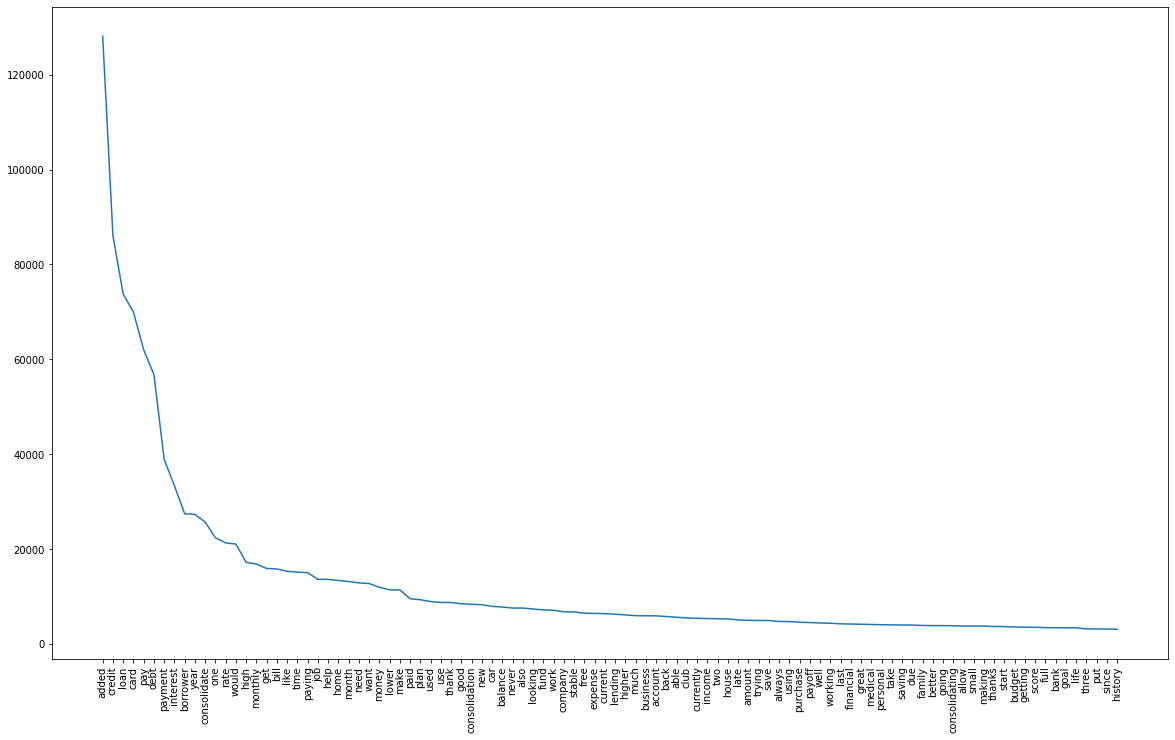

[('added', 128106), ('credit', 86072), ('loan', 73747), ('card', 69986), ('pay', 62000), ('debt', 56774), ('payment', 38923), ('interest', 33349), ('borrower', 27441), ('year', 27305), ('consolidate', 25689), ('one', 22366), ('rate', 21288), ('would', 21050), ('high', 17199), ('monthly', 16821), ('get', 15896), ('bill', 15799), ('like', 15310), ('time', 15122), ('paying', 15013), ('job', 13618), ('help', 13596), ('home', 13369), ('month', 13152), ('need', 12858), ('want', 12725), ('money', 11938), ('lower', 11377), ('make', 11373), ('paid', 9524), ('plan', 9306), ('used', 8918), ('use', 8734), ('thank', 8723), ('good', 8456), ('consolidation', 8354), ('new', 8250), ('car', 7904), ('balance', 7769)]


In [25]:
## Checking the most frequent and least occouring words and removing them. 
temp=[]
for line in raw_df.desc:
  temp.append(''.join(line))
  
temp=str(temp).split()

k=0
BOW=[]
while k<len(temp):
  if temp[k].isalnum():
    BOW.append(''.join(temp[k]))
  k=k+1

from collections import Counter
dict = Counter(BOW).most_common(100)

import matplotlib.pylab as plt

lists = sorted(dict) # sorted by key, return a list of tuples
plt.subplots(figsize=(20,12))
x, y = zip(*dict) # unpack a list of pairs into two tuples
plt.xticks(rotation=90)
plt.plot(x, y)
plt.show()

print(Counter(BOW).most_common(40))
### Based on the below graph, we will be removing the top repeating words till 'good' 
remove_list=[]
i=0
remove_dict= Counter(BOW).most_common(39)
while i < 39: 
  remove_list.append(remove_dict[i][0])
  i=i+1

#

In [26]:
print(remove_list)

['added', 'credit', 'loan', 'card', 'pay', 'debt', 'payment', 'interest', 'borrower', 'year', 'consolidate', 'one', 'rate', 'would', 'high', 'monthly', 'get', 'bill', 'like', 'time', 'paying', 'job', 'help', 'home', 'month', 'need', 'want', 'money', 'lower', 'make', 'paid', 'plan', 'used', 'use', 'thank', 'good', 'consolidation', 'new', 'car']


In [0]:
### Removing the most occouring words from remove_list and rebuilding the 'desc_cleaned' column:

filtered_sentence = [] 
final_sentence=[]

for line in raw_df.desc:
  word_tokens = word_tokenize(line)
  filtered_sentence = [] 
  for w in word_tokens: 
    if w.isalnum(): 
      if w not in remove_list: 
        filtered_sentence.append(w)
      
  final_sentence.append(' '.join(filtered_sentence))
  
df['desc'] = final_sentence

## 3.1 Visualizing desc column with Word Clouds

In [0]:
from wordcloud import WordCloud
from wordcloud import STOPWORDS as wcloud_stop

import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
%matplotlib inline 
stopwords = set(wcloud_stop)
stop_words = list(stopwords)
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='black',
        stopwords=stop_words,
        max_words=900,
        max_font_size=40, 
        scale=5,
        random_state=1
    ).generate(str(data))

    fig = plt.figure(1, figsize=(15,15))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=14)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

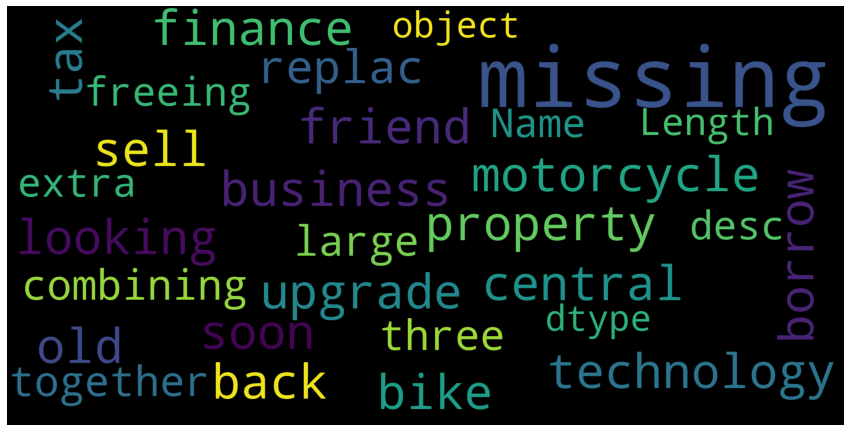

In [30]:
show_wordcloud(df["desc"])

# 4. Train/Test Split

In [31]:
raw_df['issue_d'].unique()

array(['Dec-11', 'Nov-11', 'Oct-11', 'Sep-11', 'Aug-11', 'Jul-11',
       'Jun-11', 'May-11', 'Apr-11', 'Mar-11', 'Feb-11', 'Jan-11',
       'Dec-10', 'Nov-10', 'Oct-10', 'Sep-10', 'Aug-10', 'Jul-10',
       'Jun-10', 'May-10', 'Apr-10', 'Mar-10', 'Feb-10', 'Jan-10',
       'Dec-09', 'Nov-09', 'Oct-09', 'Sep-09', 'Aug-09', 'Jul-09',
       'Jun-09', 'May-09', 'Apr-09', 'Mar-09', 'Feb-09', 'Jan-09',
       'Dec-08', 'Nov-08', 'Oct-08', 'Sep-08', 'Aug-08', 'Jul-08',
       'Jun-08', 'May-08', 'Apr-08', 'Mar-08', 'Feb-08', 'Jan-08',
       'Dec-07', 'Nov-07', 'Oct-07', 'Sep-07', 'Aug-07', 'Jul-07',
       'Jun-07', 'Dec-13', 'Nov-13', 'Oct-13', 'Sep-13', 'Aug-13',
       'Jul-13', 'Jun-13', 'May-13', 'Apr-13', 'Mar-13', 'Feb-13',
       'Jan-13', 'Dec-12', 'Nov-12', 'Oct-12', 'Sep-12', 'Aug-12',
       'Jul-12', 'Jun-12', 'May-12', 'Apr-12', 'Mar-12', 'Feb-12',
       'Jan-12', 'Dec-16', 'Nov-16', 'Oct-16'], dtype=object)

In [0]:
from datetime import datetime
from dateutil.parser import parse

In [0]:
df['issue_d'] = raw_df['issue_d']

In [0]:
df['issue_d'] =  pd.to_datetime(df['issue_d'],
                              format='%b-%y') #reference for further learning: https://www.datacamp.com/community/tutorials/converting-strings-datetime-objects

In [35]:
df['issue_d'].head()

0   2011-12-01
1   2011-12-01
2   2011-12-01
3   2011-12-01
4   2011-12-01
Name: issue_d, dtype: datetime64[ns]

In [36]:
df.head(1)

,loan_amnt,term,emp_length,loan_status,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc,tot_coll_amt,tot_cur_bal,mort_acc,pub_rec_bankruptcies,earliest_cr_line_n,fico_avg,log_annual_inc,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Source Verified,verification_status_Verified,purpose_n_life_events,purpose_n_major_purchases,purpose_n_other,initial_list_status_w,desc,issue_d
0,5000,36,10,0,0.002765,3.0,0.0,4.135101,83.7,9.0,0.0,0.0,0.0,0.0,35.33744,737.0,4.380229,0,0,1,0,1,0,0,0,0,upgrade business technology,2011-12-01


In [37]:
df['issue_d'].describe()

count                  334262
unique                     82
top       2016-12-01 00:00:00
freq                    36183
first     2007-06-01 00:00:00
last      2016-12-01 00:00:00
Name: issue_d, dtype: object

There are 82 unique issue dates over the 8-year period because we only have month/year information. In this particular dataset, the first loans were issued in June 2007, and the most recent loans were issued in Dec 2016. The busiest month was Dec 2016 with 36,183 loans funded in that month. Let's see distribution of loans funded in each year?



Text(0.5, 1.0, 'Loans Funded per Year')

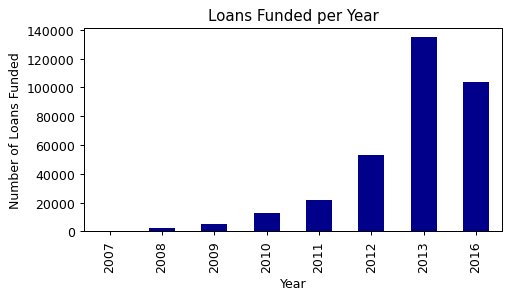

In [38]:
plt.figure(figsize=(6,3), dpi=90)
df['issue_d'].dt.year.value_counts().sort_index().plot.bar(color='darkblue')
plt.xlabel('Year')
plt.ylabel('Number of Loans Funded')
plt.title('Loans Funded per Year')

In [0]:
#We'll form the test set from the most recent 20% of the loans.
df_train = df.loc[df['issue_d'] <  df['issue_d'].quantile(0.8)]
df_test =  df.loc[df['issue_d'] >= df['issue_d'].quantile(0.8)]

In [0]:
#df_train = df_train.drop(['Unnamed: 0'],axis=1)
#df_test = df_test.drop(['Unnamed: 0'],axis=1)

In [41]:
#Check that we properly partitioned the loans:
print('Number of loans in the partition:   ', df_train.shape[0] + df_test.shape[0])
print('Number of loans in the full dataset:', df.shape[0])

Number of loans in the partition:    334262
Number of loans in the full dataset: 334262


In [42]:
#What is the test size?
df_test.shape[0] / df.shape[0]

0.21173211432947808

About 21.1%. The partition looks good, so we can delete the DF.

In [0]:
#del df

In [44]:
df_train['issue_d'].describe()

count                  263488
unique                     80
top       2016-10-01 00:00:00
freq                    32772
first     2007-06-01 00:00:00
last      2016-10-01 00:00:00
Name: issue_d, dtype: object

In [45]:
df_test['issue_d'].describe()

count                   70774
unique                      2
top       2016-12-01 00:00:00
freq                    36183
first     2016-11-01 00:00:00
last      2016-12-01 00:00:00
Name: issue_d, dtype: object

The training set includes loans from June 2007 to Oct 2016. The test set includes loans from Nov 2016 to Dec 2017.

Let's remove issue_d variable as it will not be available at the time of filling an application



In [46]:
df_train.drop('issue_d', axis=1, inplace=True)
df_test.drop('issue_d', axis=1, inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [0]:
#Now separate the predictor variables from the response variable:
y_train = df_train['loan_status']
y_val = df_test['loan_status']

In [0]:
X_train = df_train.drop('loan_status', axis=1)
X_val = df_test.drop('loan_status', axis=1)

In [0]:
# removing these are we are done with them now
#del df_train, df_test

# 2.3 NLP Continued

Let's get our binary vectors for the text field

In [0]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
 
# Initialize the binary count vectorizer #Text -> Uni gram count Vectors
tfidf_vectorizer = TfidfVectorizer(#binary=True,
                                   max_features=100    # Limit the vocabulary size
                                  )
# Fit and transform
X_train_text_vectors = tfidf_vectorizer.fit_transform(X_train["desc"].tolist())
# Only transform
X_val_text_vectors = tfidf_vectorizer.transform(X_val["desc"].tolist())

Naive Bayes algorithm uses CountVectorizer(), so we will vectorize our text data using count vectorizer. Let's also experiment with max_features and ngram parameters in below lines.
Realize that we called the fit() function only once on training data. This is because we want to test our method on unseen words as well.

In [52]:
print(tfidf_vectorizer.vocabulary_)

{'business': 13, 'finance': 33, 'looking': 56, 'college': 18, 'missing': 61, 'back': 8, 'last': 50, 'three': 90, 'always': 4, 'budget': 12, 'due': 25, 'medical': 58, 'stable': 85, 'using': 93, 'fund': 38, 'two': 92, 'well': 96, 'bank': 10, 'small': 84, 'going': 42, 'also': 3, 'buy': 14, 'score': 81, 'mortgage': 62, 'trying': 91, 'history': 45, 'work': 98, 'full': 37, 'repair': 77, 'house': 46, 'thanks': 89, 'financial': 34, 'since': 83, 'account': 1, 'close': 16, 'within': 97, 'start': 86, 'lending': 53, 'payoff': 68, 'club': 17, 'purchase': 72, 'current': 23, 'take': 88, 'really': 74, 'family': 31, 'several': 82, 'balance': 9, 'expense': 30, 'never': 64, 'saving': 79, 'every': 28, 'please': 71, 'put': 73, 'income': 48, 'consideration': 20, 'making': 57, 'late': 51, 'able': 0, 'great': 43, 'better': 11, 'save': 78, 'future': 39, 'minimum': 59, 'company': 19, 'currently': 24, 'le': 52, 'allow': 2, 'order': 66, 'per': 69, 'amp': 6, 'next': 65, 'life': 54, 'working': 99, 'much': 63, 'stud

In [0]:
X_train = X_train.drop(['desc'],axis=1) #dropping desc from X_train as we have processed it in X_train_text_vectors
X_val = X_val.drop(['desc'],axis=1) #dropping desc from X_val as well as we have processed it in X_val_text_vectors

In [0]:
# Let' merge our features
X_train_features = np.column_stack((X_train_text_vectors.toarray(), 
                                    X_train)
                                  )
# Let' merge our features
X_val_features = np.column_stack((X_val_text_vectors.toarray(), 
                                    X_val)
                                  )

We this we have merged our text column with rest of the predictos after getting binary vectors for the textual data

In [55]:
print("Training Data Size: ", X_train.shape)
print("Validation Data Size: ", X_val.shape)

Training Data Size:  (263488, 25)
Validation Data Size:  (70774, 25)


# 5. Saving and Downloading train and test CSV files with inclusion of cleaned desc

In [0]:
from google.colab import files
df_train.to_csv('/content/drive/My Drive/Lending_Club/df_NLP_Split.csv') 
df_test.to_csv('/content/drive/My Drive/Lending_Club/df_NLP_Split.csv') 
files.download('/content/drive/My Drive/Lending_Club/df_NLP_Split.csv')
files.download('/content/drive/My Drive/Lending_Club/df_NLP_Split.csv')

# 6. Creating Pickle to be able to read the DF from this notebook's checkpoint

In [0]:
df_train.to_pickle("/content/drive/My Drive/Lending_Club/loan_NLP_split_train.pkl")
df_test.to_pickle("/content/drive/My Drive/Lending_Club/loan_NLP_split_test.pkl")

In next notebook, I will start modeling on the train and test arrays that we created in this notebook which will have desc column binary vectors too.